In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import os,time,sys
import keras
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tqdm import tqdm
from tensorflow.keras.utils import Sequence

from  textwrap import wrap

In [ ]:
import zipfile
import os

zip_file = "/content/Flickr8k_Dataset.zip"

extract_dic ="/content/Extracted_Folder"

os.makedirs(extract_dic, exist_ok=True)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dic)

print("Extraction complete.")

Extraction complete.


In [ ]:
#Importing image dataset and its Captions

dir_Img = r"/content/Extracted_Folder/Flicker8k_Dataset"
dir_text = r"/content/captions.txt"

jpgs = os.listdir(dir_Img)
print("Number of jpg in files :",len(jpgs))

Number of jpg in files : 8091


In [ ]:
data = pd.read_csv(dir_text)
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def readImage(path,img_size = 224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.0
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)

    plt.figure(figsize=(20,30))
    n=0
    for i in range(5):
        n +=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace=0.7,wspace=0.3)
        image = readImage(f"/content/Extracted_Folder/Flicker8k_Dataset/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i],20)))
        plt.axis("off")


# Visualization
 - Images and their corresponding caption

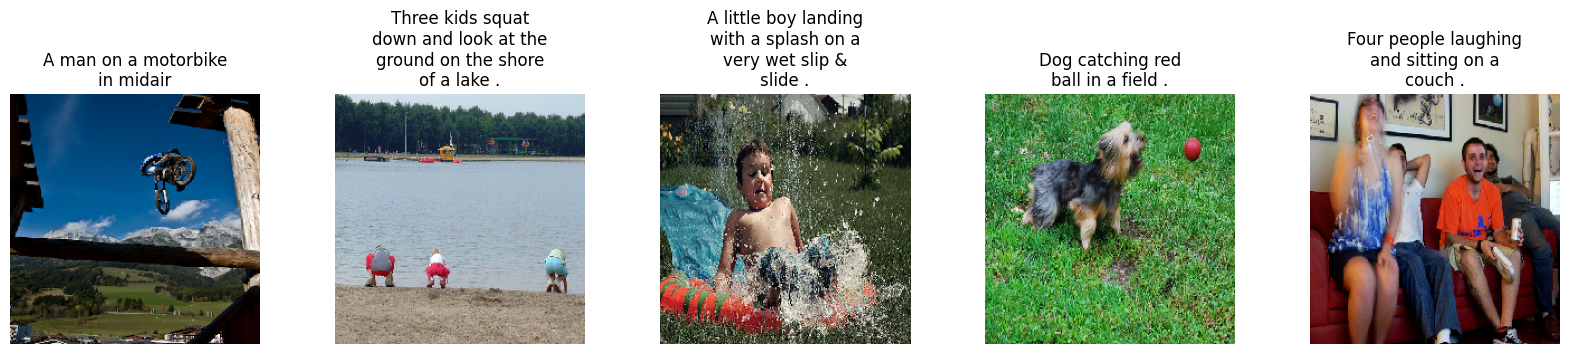

In [ ]:
display_images(data.sample(15))

# Caption Text Preprocessing Steps
 - Convert sentences into lowercase
 - Remove special characters and number present in the text
 - Remove extra spaces
 - Remove single Characters
 - Add a starting and an ending tag to the sentences to indicate the beginning and the ending of the sentence


In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace(r'[^A-Za-z]',""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq " + data['caption'] +' endseq'
    return data

In [ ]:
data['caption']

,caption
0,A child in a pink dress is climbing up a set o...
1,A girl going into a wooden building .
2,A little girl climbing into a wooden playhouse .
3,A little girl climbing the stairs to her playh...
4,A little girl in a pink dress going into a woo...
...,...
40450,A man in a pink shirt climbs a rock face
40451,A man is rock climbing high in the air .
40452,A person in a red shirt climbing up a rock fac...
40453,A rock climber in a red shirt .


Preprocessed Text

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index)+1
max_length = max(len(caption.split() )for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]


[1, 18, 315, 63, 195, 116, 2]

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
# We convert image to 224
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(dir_Img, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

print(features)

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


100%|██████████| 8091/8091 [14:16<00:00,  9.44it/s]


{'1000268201_693b08cb0e.jpg': array([[7.8687925e-05, 7.3524064e-04, 1.1395994e-03, ..., 5.6523526e-01,
        2.2903718e-01, 6.9639677e-01]], dtype=float32), '1001773457_577c3a7d70.jpg': array([[1.2493606e-04, 4.5205734e-04, 1.9292446e-03, ..., 7.4856892e-02,
        2.0473881e+00, 9.0312496e-02]], dtype=float32), '1002674143_1b742ab4b8.jpg': array([[5.0413997e-05, 3.7103010e-04, 1.9412232e-03, ..., 8.7596454e-02,
        4.6891534e-01, 3.1746176e-01]], dtype=float32), '1003163366_44323f5815.jpg': array([[1.4095564e-04, 7.7881810e-04, 1.2702045e-03, ..., 2.2357789e-01,
        8.1238449e-02, 1.3331205e-01]], dtype=float32), '1007129816_e794419615.jpg': array([[9.8224300e-05, 7.2486623e-04, 1.8896530e-03, ..., 1.9271162e+00,
        1.3698275e+00, 1.7164363e-01]], dtype=float32), '1007320043_627395c3d8.jpg': array([[1.3486607e-04, 3.0726852e-04, 9.5219765e-04, ..., 2.6253685e-01,
        2.8394349e-02, 1.3737245e+00]], dtype=float32), '1009434119_febe49276a.jpg': array([[1.0609256e-04,

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
class CustomDataGenerator(Sequence):
    def __init__(self,df,x_col,y_col,batch_size,directory,tokenizer,vocab_size,max_length,features,shuffle=True):

        self.df = df
        self.x_col = x_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.directory = directory
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length=max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)


    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__ (self):
        return self.n // self.batch_size

    def __getitem__(self,index):
        batch = self.df.iloc[index*self.batch_size:(index +1)*self.batch_size,:]
        x1, x2,y = self.__get_data(batch)
        return (x1,x2), y


    def __get_data(self,batch):

        x1, x2, y = list(), list(), list()

        images = batch[self.x_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.x_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    x1.append(feature)
                    x2.append(in_seq)
                    y.append(out_seq)

        x1, x2, y = np.array(x1), np.array(x2), np.array(y)

        return x1, x2, y





In [ ]:

input_1 = tf.keras.layers.Input(shape=(1920,))
input_2 = tf.keras.layers.Input(shape=(max_length,))

img_feature = tf.keras.layers.Dense(256, activation='relu')(input_1)
img_feature_reshape = tf.keras.layers.Reshape((1, 256), input_shape=(256,))(img_feature)

sentenc_feature = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=False)(input_2)
merged = tf.keras.layers.concatenate([img_feature_reshape, sentenc_feature], axis=1)
sentenc_feature = tf.keras.layers.LSTM(256)(merged)
x = tf.keras.layers.Dropout(0.5)(sentenc_feature)
x = tf.keras.layers.add([x, img_feature])
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input_1, input_2], outputs=output)
caption_model.compile(optimizer='Adam', loss='categorical_crossentropy')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.utils import plot_model

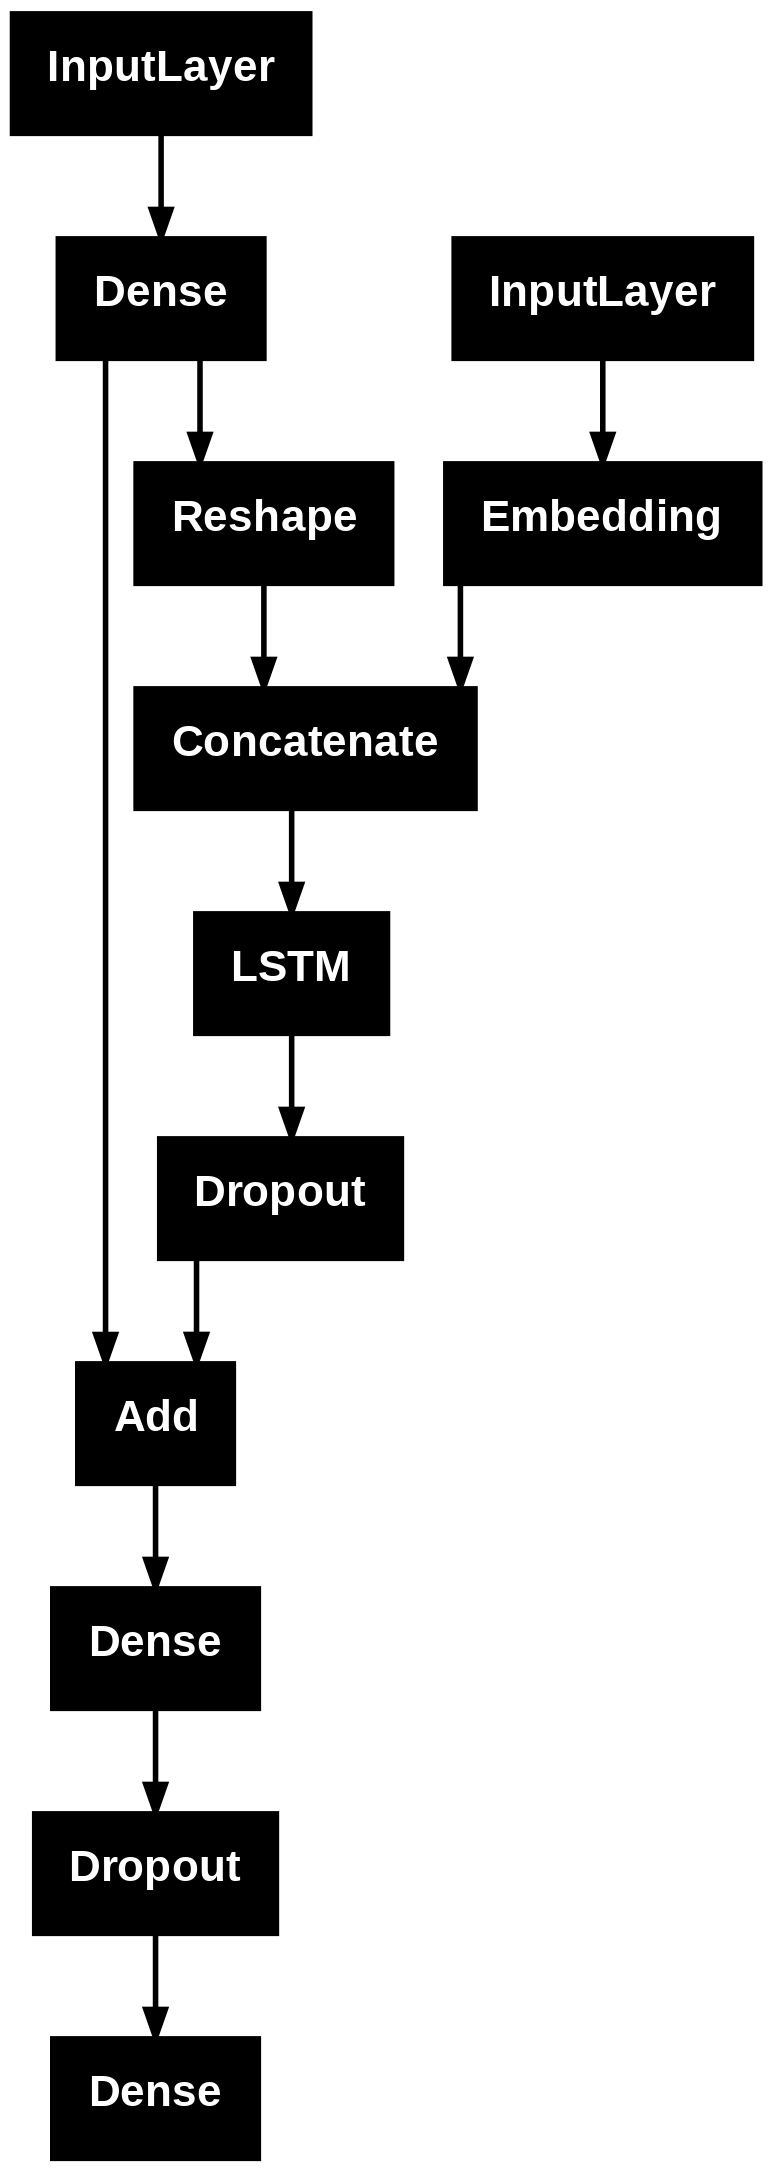

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 1920)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 256)            │        491,776 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 256)         │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 34, 256)        │      2,172,160 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 35, 256)        │              0 │ reshape_5[0][0],       │
│ (Concatenate)             │                        │                │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 256)            │        525,312 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 256)            │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 256)            │              0 │ dropout_10[0][0],      │
│                           │                        │                │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 128)            │         32,896 │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128)            │              0 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 8485)           │      1,094,565 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,316,709 (16.47 MB)

 Trainable params: 4,316,709 (16.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_generator =CustomDataGenerator(df=train,x_col='image',y_col='caption',batch_size=64,directory=dir_Img,tokenizer=tokenizer,vocab_size =vocab_size,max_length=max_length,features=features)
validation_generator = CustomDataGenerator(df=test,x_col='image',y_col='caption',batch_size=64,directory=dir_Img,tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_name = "model.keras"
check_point = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.0000001)


In [ ]:
history = caption_model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks=[check_point,earlyStopping,learning_rate])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - loss: 5.6851
Epoch 1: val_loss improved from inf to 4.17125, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 394s 713ms/step - loss: 5.6839 - val_loss: 4.1712 - learning_rate: 0.0010
Epoch 2/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 4.1955
Epoch 2: val_loss improved from 4.17125 to 3.88033, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 154s 193ms/step - loss: 4.1953 - val_loss: 3.8803 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 3.9176
Epoch 3: val_loss improved from 3.88033 to 3.75656, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 134s 179ms/step - loss: 3.9176 - val_loss: 3.7566 - learning_rate: 0.0010
Epoch 4/50
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 3.7535
Epoch 4: val_loss improved from 3.75656 to 3.68263, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 97s 180ms/step - loss: 3.7535 - val_loss: 3.6826 - learning_rate: 0.0010
Epoch 5/

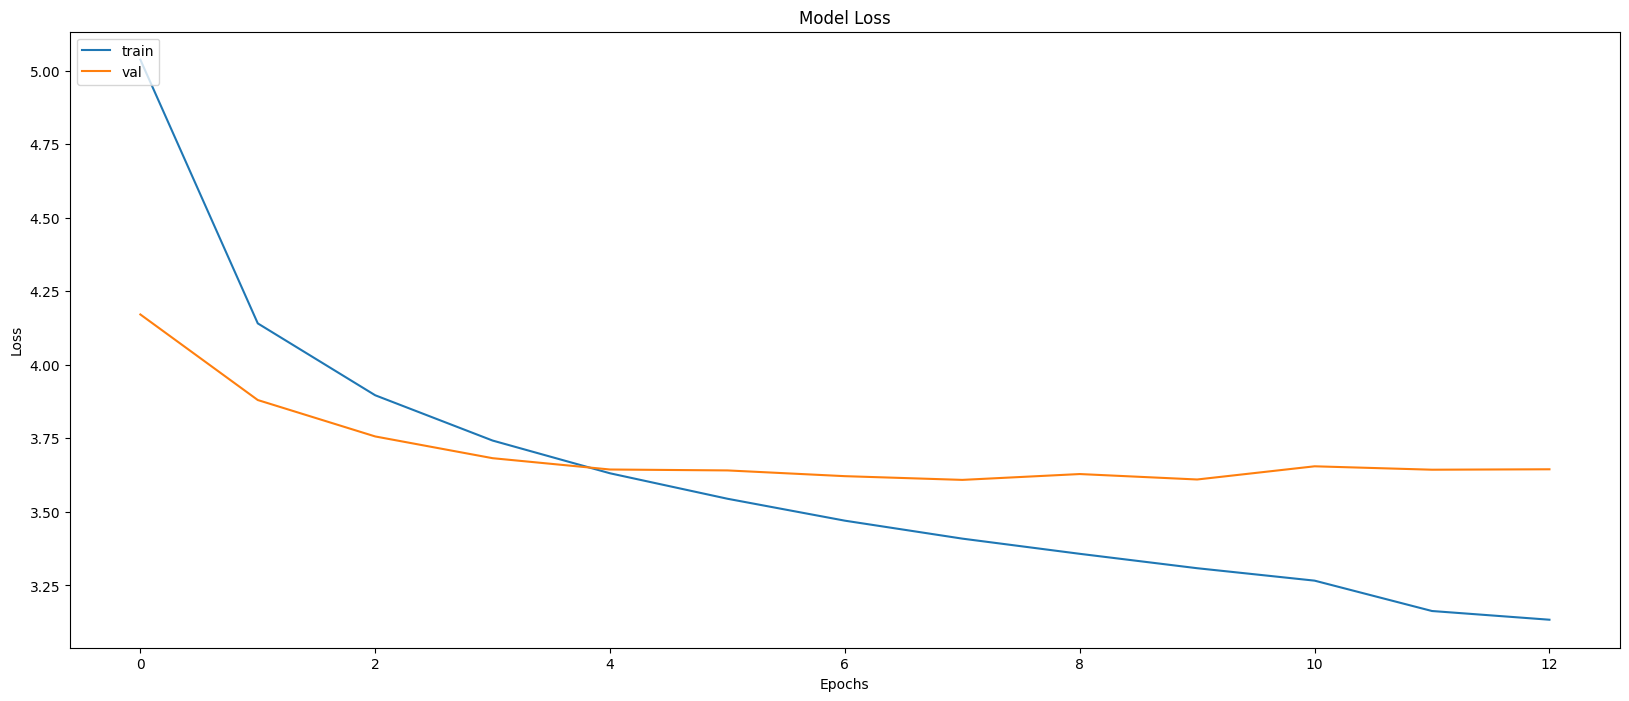

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'],loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer,tokenizer):

    for word , index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model,image,tokenizer,max_length,features):

    feature = features[image]
    in_text = 'startseq '
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]

        sequence = pad_sequences([sequence],max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred,tokenizer)

        if word is None :
            break

        in_text +=" "+word

        if word == 'endseq':
            break
    return in_text

In [ ]:
samples = test.sample(15)

samples.reset_index(drop=True,inplace=True)


In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(dir_Img,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255


    caption = predict_caption(caption_model,record['image'],tokenizer,max_length,features)
    samples.loc[index,'caption'] = caption

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━

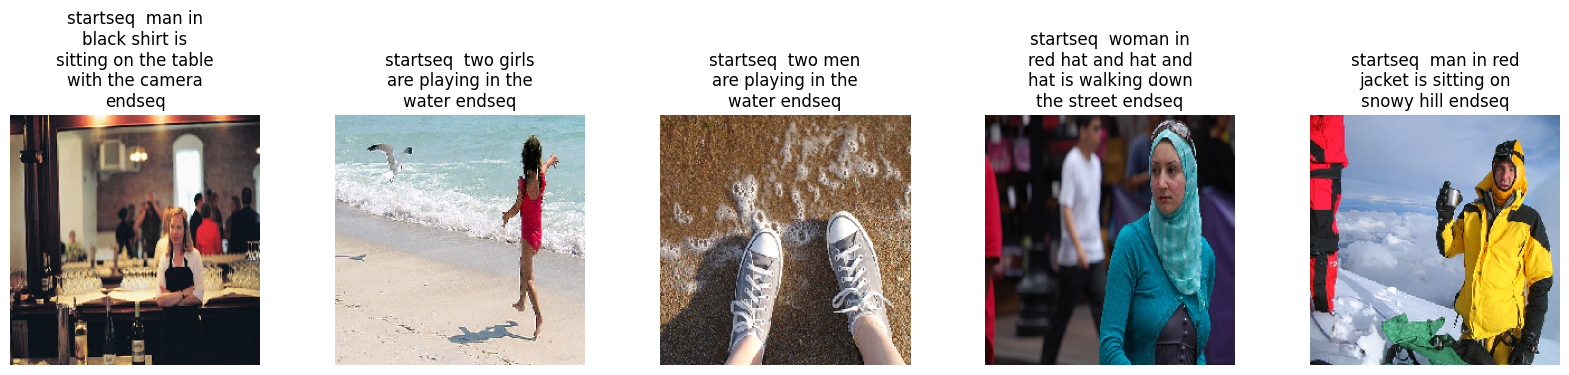

In [ ]:
display_images(samples)